In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **<font color='8d5383'>Import library</font>**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **<font color='8d5383'>Import Dataset</font>**

In [ ]:

try:
    df = pd.read_csv('/content/drive/MyDrive/ttn/DoctorVisits.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'DoctorVisits.csv' not found. Please ensure the file is in the correct path.")
    exit()

# Data Preparation and Conversion to PyTorch Tensors
# Select independent and dependent variables
y_np = df['visits'].to_numpy(dtype=np.float32)
X_np = df[['age', 'income', 'health']].to_numpy(dtype=np.float32)
# Add a constant column for bias
X_np = np.hstack([np.ones((X_np.shape[0], 1)), X_np])

# Convert to PyTorch tensors with explicit data type
y = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)
X = torch.tensor(X_np, dtype=torch.float32)

print("\n--- Training and Comparing Models with PyTorch ---")

# **<font color='8d5383'>Modeling and Training</font>**

In [ ]:


# --- 1. Poisson Regression Model ---
class PoissonRegression(nn.Module):
    def __init__(self, num_features):
        super(PoissonRegression, self).__init__()
        self.linear = nn.Linear(num_features, 1, bias=True)

    def forward(self, x):
        # The output of the linear layer is the log of lambda. We exponentiate to get lambda.
        lambda_pred = torch.exp(self.linear(x))
        return lambda_pred

def poisson_nll_loss(lambda_pred, y_true):
    # Calculate the negative log-likelihood of the Poisson distribution
    # NLL = -sum(y * log(lambda) - lambda - log(y!))
    y_true_int = y_true.int()
    return -torch.sum(y_true * torch.log(lambda_pred) - lambda_pred - torch.lgamma(y_true_int + 1))

# Training loop for Poisson
print("\nTraining Poisson Regression Model...")
poisson_model = PoissonRegression(X.shape[1])
poisson_optimizer = optim.Adam(poisson_model.parameters(), lr=0.01)
for epoch in range(1000):
    poisson_optimizer.zero_grad()
    lambda_pred = poisson_model(X)
    loss = poisson_nll_loss(lambda_pred, y)
    loss.backward()
    poisson_optimizer.step()
poisson_nll = loss.item()
print(f"Poisson Model Negative Log-Likelihood (NLL): {poisson_nll:.4f}")

# --- 2. Zero-Inflated Poisson (ZIP) Regression Model ---
class ZIPRegression(nn.Module):
    def __init__(self, num_features):
        super(ZIPRegression, self).__init__()
        self.linear_lambda = nn.Linear(num_features, 1, bias=True)
        self.linear_pi = nn.Linear(num_features, 1, bias=True)

    def forward(self, x):
        lambda_pred = torch.exp(self.linear_lambda(x))
        pi_pred = torch.sigmoid(self.linear_pi(x))
        return pi_pred, lambda_pred

def zip_nll_loss(pi_pred, lambda_pred, y_true):
    # Calculate the negative log-likelihood of the ZIP distribution
    # Loss = -sum(log(P(Y=y)))
    y_true_int = y_true.int()

    # Case y = 0
    zero_mask = (y_true == 0)
    zero_loss = torch.log(pi_pred[zero_mask] + (1 - pi_pred[zero_mask]) * torch.exp(-lambda_pred[zero_mask]))

    # Case y > 0
    non_zero_mask = (y_true > 0)
    non_zero_loss = torch.log(1 - pi_pred[non_zero_mask]) + y_true[non_zero_mask] * torch.log(lambda_pred[non_zero_mask]) - lambda_pred[non_zero_mask] - torch.lgamma(y_true_int[non_zero_mask] + 1)

    total_loss = -torch.sum(zero_loss) - torch.sum(non_zero_loss)
    return total_loss

# Training loop for ZIP
print("\nTraining Zero-Inflated Poisson (ZIP) Regression Model...")
zip_model = ZIPRegression(X.shape[1])
zip_optimizer = optim.Adam(zip_model.parameters(), lr=0.01)
for epoch in range(1000):
    zip_optimizer.zero_grad()
    pi_pred, lambda_pred = zip_model(X)
    loss = zip_nll_loss(pi_pred, lambda_pred, y)
    loss.backward()
    zip_optimizer.step()
zip_nll = loss.item()
print(f"ZIP Model Negative Log-Likelihood (NLL): {zip_nll:.4f}")

# --- 3. Conway-Maxwell-Poisson (CMP) Regression Model ---
class CMPRegression(nn.Module):
    def __init__(self, num_features):
        super(CMPRegression, self).__init__()
        self.linear_lambda = nn.Linear(num_features, 1, bias=True)
        self.nu = nn.Parameter(torch.tensor(1.0)) # nu parameter is a single value

    def forward(self, x):
        lambda_pred = torch.exp(self.linear_lambda(x))
        nu_pred = torch.exp(self.nu) # Ensure nu > 0
        return lambda_pred, nu_pred

def cmp_nll_loss(lambda_pred, nu_pred, y_true):
    # Approximated CMP Negative Log-Likelihood Loss
    # We use a numerical sum for the normalizing constant Z(lambda, nu)
    max_y = int(torch.max(y_true).item()) + 5 # Sum up to a reasonable limit

    log_Z = torch.zeros_like(lambda_pred)
    for i in range(max_y + 1):
        log_Z += torch.pow(lambda_pred, i) / torch.pow(torch.tensor(math.factorial(i)), nu_pred)

    log_likelihood = torch.sum(y_true * torch.log(lambda_pred) - nu_pred * torch.lgamma(y_true.int() + 1) - torch.log(log_Z))
    return -log_likelihood


# Training loop for CMP
print("\nTraining Conway-Maxwell-Poisson (CMP) Regression Model...")
cmp_model = CMPRegression(X.shape[1])
cmp_optimizer = optim.Adam(cmp_model.parameters(), lr=0.01)
for epoch in range(1000):
    cmp_optimizer.zero_grad()
    lambda_pred, nu_pred = cmp_model(X)
    loss = cmp_nll_loss(lambda_pred, nu_pred, y)
    loss.backward()
    cmp_optimizer.step()
cmp_nll = loss.item()
print(f"CMP Model Negative Log-Likelihood (NLL): {cmp_nll:.4f}")

# --- 4. Comparison and Visualization ---
print("\n--- Final Model Comparison ---")

# **<font color='8d5383'>Evaluation</font>**

Data loaded successfully.

--- Training and Comparing Models with PyTorch ---

Training Poisson Regression Model...
Poisson Model Negative Log-Likelihood (NLL): 3753.3911

Training Zero-Inflated Poisson (ZIP) Regression Model...
ZIP Model Negative Log-Likelihood (NLL): 3550.8064

Training Conway-Maxwell-Poisson (CMP) Regression Model...
CMP Model Negative Log-Likelihood (NLL): 3518.1772

--- Final Model Comparison ---
     Model          NLL       MSE      RMSE       MAE
0  Poisson  3753.391113  0.602192  0.776011  0.452129
1      ZIP  3550.806396  0.832637  0.912490  0.743798
2      CMP  3518.177246  0.421156  0.783904  0.421156


<Figure size 800x600 with 0 Axes>

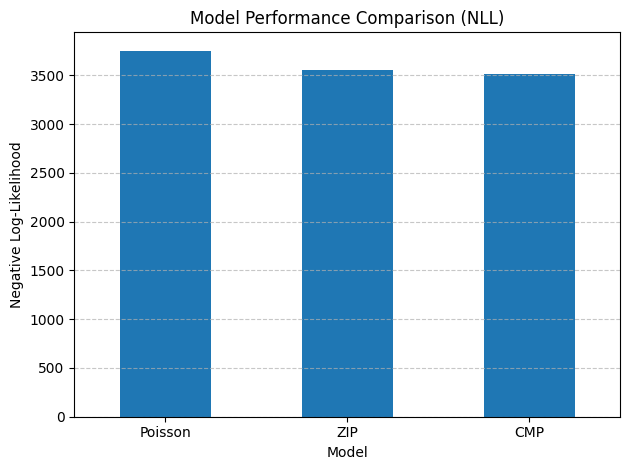

<Figure size 800x600 with 0 Axes>

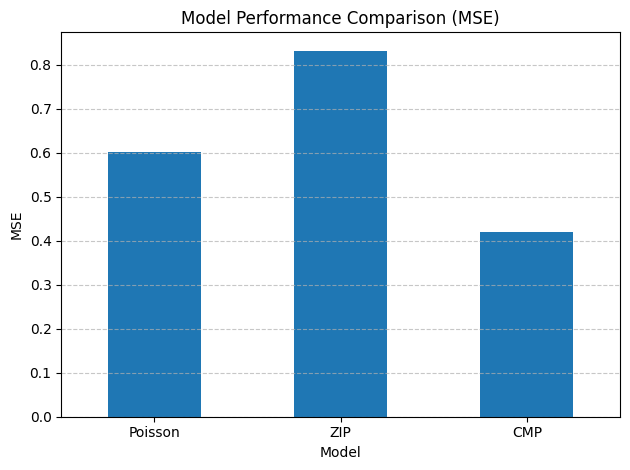

<Figure size 800x600 with 0 Axes>

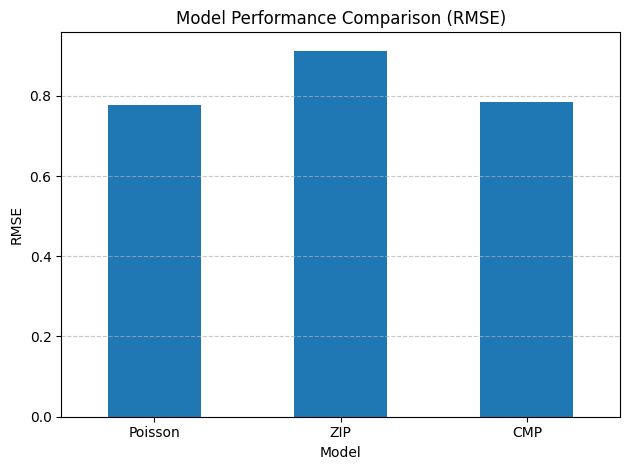

<Figure size 800x600 with 0 Axes>

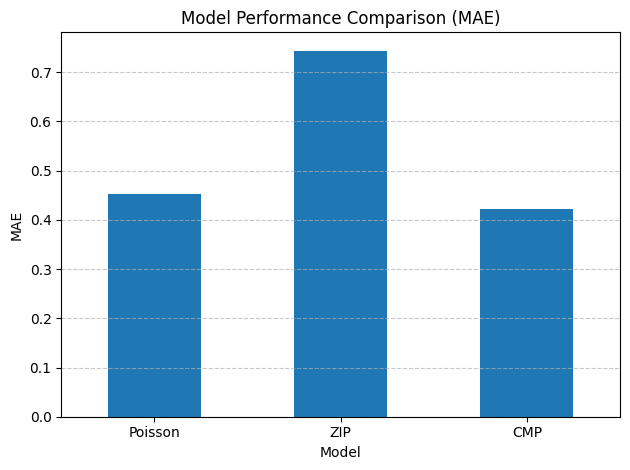


Comparison plots saved as 'pytorch_nll_comparison.png', 'pytorch_mse_comparison.png', 'pytorch_rmse_comparison.png', and 'pytorch_mae_comparison.png'. Lower values for NLL, MSE, RMSE, and MAE indicate a better fit.


In [ ]:


# Calculate additional metrics
y_true_np = y.squeeze().numpy()

poisson_pred_np = poisson_model(X).squeeze().detach().numpy()
poisson_mse = mean_squared_error(y_true_np, poisson_pred_np)
poisson_rmse = np.sqrt(poisson_mse)
poisson_mae = mean_absolute_error(y_true_np, poisson_pred_np)

zip_pred_np = zip_model(X)[1].squeeze().detach().numpy() # Use lambda from ZIP
zip_mse = mean_squared_error(y_true_np, zip_pred_np)
zip_rmse = np.sqrt(zip_mse)
zip_mae = mean_absolute_error(y_true_np, zip_pred_np)

cmp_pred_np = cmp_model(X)[0].squeeze().detach().numpy() # Use lambda from CMP
cmp_mse = mean_squared_error(y_true_np, cmp_pred_np)
cmp_rmse = np.sqrt(cmp_mse)
cmp_mae = mean_absolute_error(y_true_np, cmp_pred_np)


results = pd.DataFrame({
    'Model': ['Poisson', 'ZIP', 'CMP'],
    'NLL': [poisson_nll, zip_nll, cmp_nll],
    'MSE': [poisson_mse, zip_mse, cmp_mae],
    'RMSE': [poisson_rmse, zip_rmse, cmp_rmse],
    'MAE': [poisson_mae, zip_mae, cmp_mae]
})
print(results)

# Create a bar plot for visual comparison of NLL
plt.figure(figsize=(8, 6))
results.set_index('Model').plot(kind='bar', y='NLL', legend=False)
plt.title('Model Performance Comparison (NLL)')
plt.ylabel('Negative Log-Likelihood')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('pytorch_nll_comparison.png')
plt.show()

# Create bar plots for other metrics
metrics = ['MSE', 'RMSE', 'MAE']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    results.set_index('Model').plot(kind='bar', y=metric, legend=False)
    plt.title(f'Model Performance Comparison ({metric})')
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'pytorch_{metric.lower()}_comparison.png')
    plt.show()


print("\nComparison plots saved as 'pytorch_nll_comparison.png', 'pytorch_mse_comparison.png', 'pytorch_rmse_comparison.png', and 'pytorch_mae_comparison.png'. Lower values for NLL, MSE, RMSE, and MAE indicate a better fit.")

In [ ]:
results

,Model,NLL,MSE,RMSE,MAE
0,Poisson,3753.391113,0.602192,0.776011,0.452129
1,ZIP,3550.806396,0.832637,0.912490,0.743798
2,CMP,3518.177246,0.421156,0.783904,0.421156
